In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
train_data = pd.read_csv("E:\\学\\数据处理\\titanic\\train.csv")
test_data = pd.read_csv("E:\\学\\数据处理\\titanic\\test.csv")
all_data = pd.concat([train_data, test_data])
all_data.drop(columns=["Survived"]).describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200


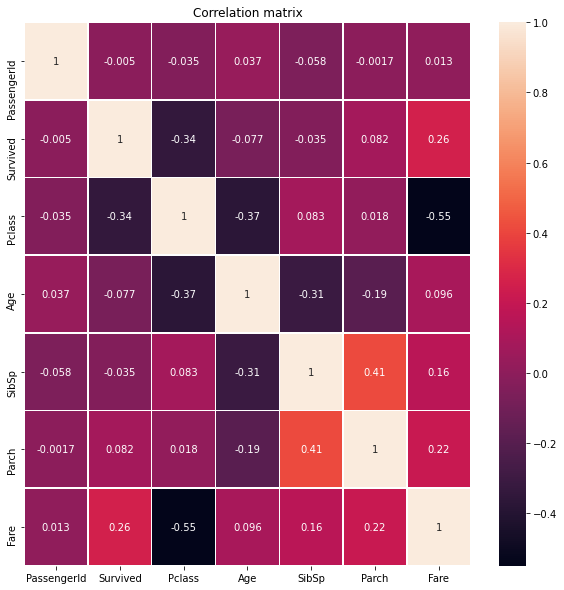

In [17]:
survival_rate = train_data["Survived"].mean()
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)
corr = train_data.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(corr, annot=True, linewidth=0.5)
ax.set_title("Correlation matrix")
plt.show()

Text(0.5, 1.08, 'Pairplots')

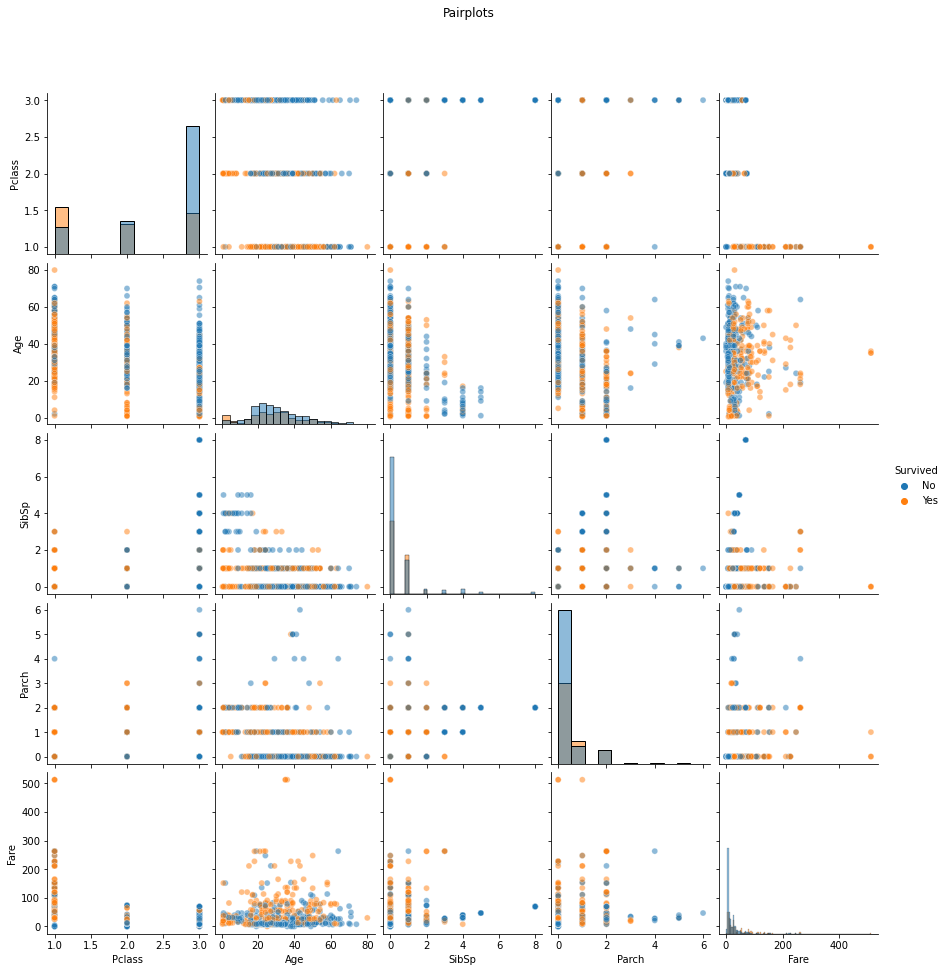

In [3]:
ax = sns.pairplot(train_data.drop(columns=["PassengerId"]).replace({"Survived": {0:"No", 1:"Yes"}}),
                                                                    hue="Survived",
                                                                    plot_kws={"alpha":0.5},
                                                                    diag_kind="hist")
ax.fig.suptitle("Pairplots", y=1.08)

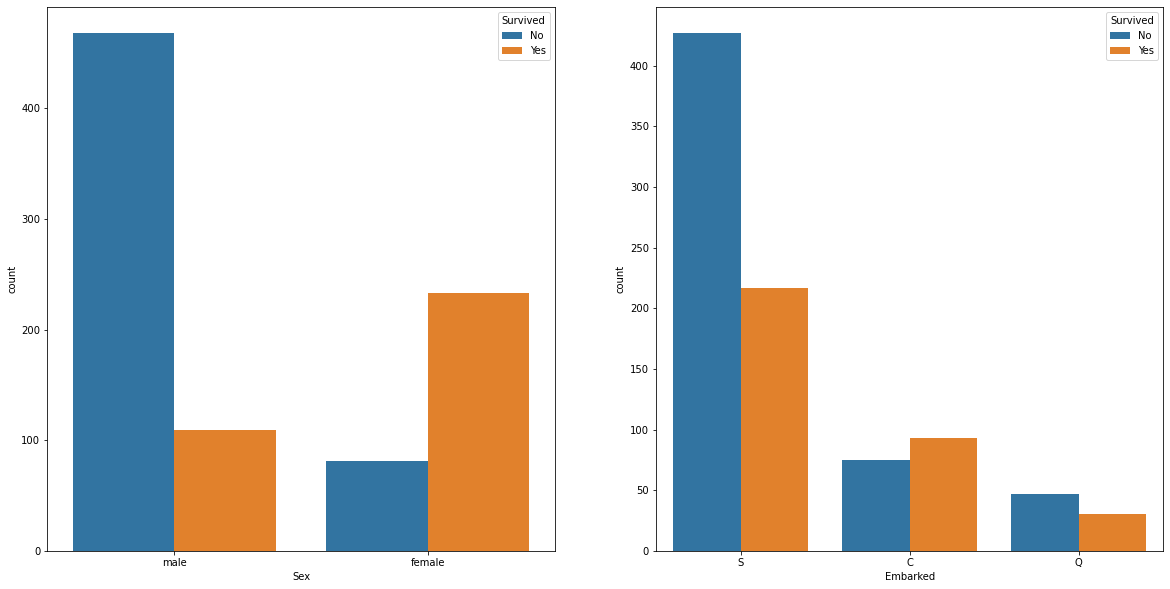

In [4]:
to_show_features = ["Sex", "Embarked"]
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.countplot(x=train_data[to_show_features[0]], hue='Survived', data=train_data.replace({"Survived": {0:"No", 1:"Yes"}}), ax=axs[0])
sns.countplot(x=train_data[to_show_features[1]], hue='Survived', data=train_data.replace({"Survived": {0:"No", 1:"Yes"}}), ax=axs[1])
plt.show()

In [5]:
train_data.loc[train_data["Sex"] == "male"]["Embarked"]

0      S
4      S
5      Q
6      S
7      S
      ..
883    S
884    S
886    S
889    C
890    Q
Name: Embarked, Length: 577, dtype: object

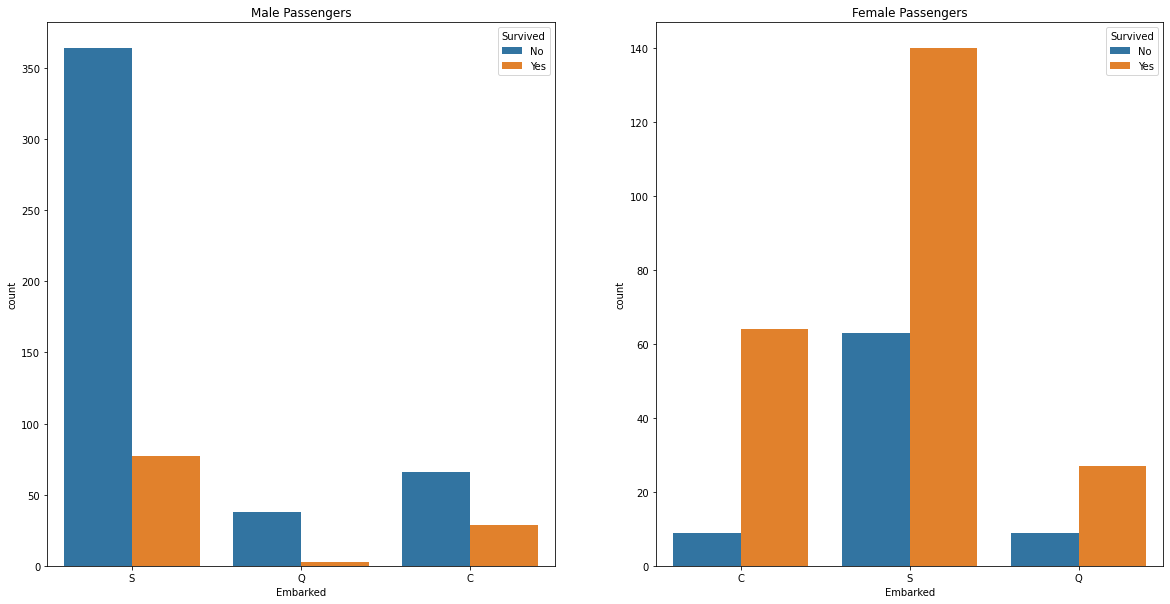

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
sns.countplot(x=train_data.loc[train_data["Sex"] == "male"]["Embarked"], hue='Survived', data=train_data.replace({"Survived": {0:"No", 1:"Yes"}}), ax=axs[0])
axs[0].set_title("Male Passengers")
sns.countplot(x=train_data.loc[train_data["Sex"] == "female"]["Embarked"], hue='Survived', data=train_data.replace({"Survived": {0:"No", 1:"Yes"}}), ax=axs[1])
axs[1].set_title("Female Passengers")
plt.show()

Text(0.5, 1.0, 'Class distribution of Male Passenger from Southampton')

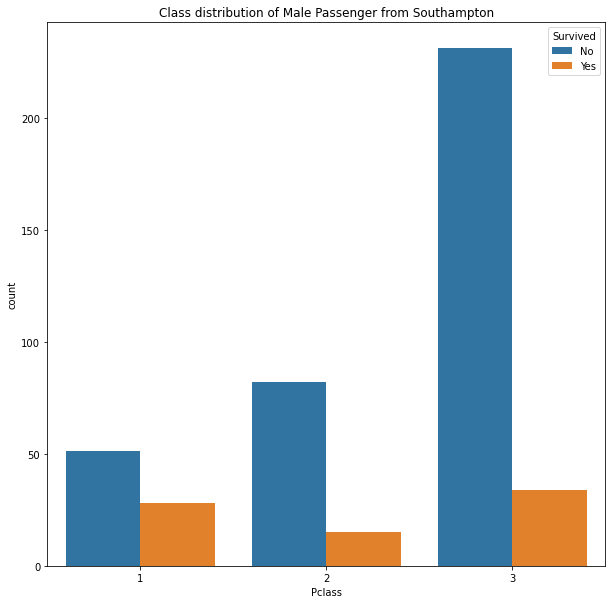

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.countplot(x=train_data.loc[(train_data["Sex"] == "male") & (train_data["Embarked"] == "S")]["Pclass"],
              hue='Survived', data=train_data.replace({"Survived": {0:"No", 1:"Yes"}}), ax=ax)
ax.set_title("Class distribution of Male Passenger from Southampton")

In [8]:
features = ["Pclass", "Sex", "SibSp", "Parch", "Age", "Embarked"]
X_train = pd.get_dummies(train_data[features])
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
X_train = imputer.fit_transform(X_train)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
y_train = np.array(train_data["Survived"])
def trainClassifier(X_train, y_train, model_name, classifier, params, score, verbose=False, num_folds=10):
    kf = sklearn.model_selection.StratifiedKFold(num_folds)     
    train_scores = []
    best_score = 0    
    for config in sklearn.model_selection.ParameterGrid(params):
        train_scores_run = []
        counts = []
        for train_indices, valid_indices in kf.split(X_train, y_train):
            counts.append(len(train_indices))
            X_train_kf = X_train[train_indices]
            y_train_kf = y_train[train_indices]
            X_valid_kf = X_train[valid_indices]
            y_valid_kf = y_train[valid_indices]
            model = classifier(**config)
            model.fit(X_train_kf, y_train_kf)
            y_hat = model.predict(X_valid_kf)
            train_score = score(y_valid_kf, y_hat)
            train_scores_run.append(train_score)
        if np.average(train_scores_run, weights=counts) > best_score:
            best_score = np.average(train_scores_run, weights=counts)
            best_config = config
            if(verbose):
                print("New best score obtained")
                print(f"Training with: {config}")
                print(f"Total Score obtained with cross validation: {best_score}\n")
        train_scores.append(np.average(train_scores_run, weights=counts))
    output_df = pd.DataFrame(data = [[model_name, best_config ,best_score]], \
        columns=["model_name", "parameters", "training_score"])
    return output_df
results = pd.DataFrame()

In [9]:
from sklearn.neighbors import KNeighborsClassifier
params = {
    "n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15]
}
classifier = KNeighborsClassifier
classifier_df = trainClassifier(X_train, y_train, "k-NN", classifier, params, accuracy_score)
results = results.append(classifier_df)

In [10]:
from sklearn.svm import LinearSVC
params = {
    "C": [1e-3, 1e-2, 1e-1, 1],
    "max_iter": [30000]
}
classifier = LinearSVC
classifier_df = trainClassifier(X_train, y_train, "LinearSVC", classifier, params, accuracy_score)
results = results.append(classifier_df)

In [11]:
from sklearn.svm import SVC
params = {
    "kernel" : ["rbf"],
    "C": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
    "gamma": [1e-3, 1e-2, 1e-1, 1, 10]
}
classifier = SVC
classifier_df = trainClassifier(X_train, y_train, "SVC", classifier, params, accuracy_score)
results = results.append(classifier_df)

In [12]:
from sklearn.linear_model import LogisticRegression
params = {
    "C": [1e-3, 1e-2, 1e-1, 1, 10]
}
classifier = LogisticRegression
classifier_df = trainClassifier(X_train, y_train, "LogisticRegression", classifier, params, accuracy_score)
results = results.append(classifier_df)

In [13]:
from sklearn.ensemble import RandomForestClassifier
params = {"max_depth": [3, 5, 7, 10, None],
          "n_estimators":[3, 5,10, 25, 50],
          "max_features": [1, 2, "auto"]}
classifier = RandomForestClassifier
classifier_df = trainClassifier(X_train, y_train, "RandomForests", classifier, params, accuracy_score)
results = results.append(classifier_df)

In [14]:
results = results.set_index("model_name")
results

,parameters,training_score
model_name,,
k-NN,{'n_neighbors': 3},0.823906
LinearSVC,"{'C': 0.001, 'max_iter': 30000}",0.809187
SVC,"{'C': 1, 'gamma': 10, 'kernel': 'rbf'}",0.823809
LogisticRegression,{'C': 10},0.799115
RandomForests,"{'max_depth': 7, 'max_features': 2, 'n_estimat...",0.829456


In [15]:
classifier = RandomForestClassifier
best_params = results.loc["RandomForests"]["parameters"]
submission_model = classifier(**best_params)
submission_model.fit(X_train, y_train)
X_test = pd.get_dummies(test_data[features])
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)
y_hat = submission_model.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_hat})
output.to_csv('submission.csv', index=False)